# Data 602 Project 2: Crime Network

# Intro
This bipartite network contains persons who appeared in at least one crime case as either a suspect, a victim, a witness or both a suspect and victim at the same time. A left node represents a person and a right node represents a crime. An edge between two nodes shows that the left node was involved in the crime represented by the right node.The data can be found here: http://konect.uni-koblenz.de/networks/moreno_crime


# Load Data 

In [27]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 20)
import networkx.algorithms.bipartite as bp

In [41]:
#Crime data
crime = "https://raw.githubusercontent.com/dquarshie89/Data-620/master/Project%202/out.moreno_crime_crime"
crime = pd.read_csv(crime, delim_whitespace=True, header=None, skiprows=[0,1], names=['Person', 'Crime'])

#Relationship data
rel = "https://raw.githubusercontent.com/dquarshie89/Data-620/master/Project%202/rel.moreno_crime_crime.person.role"
crime['Relationship'] = pd.read_csv(rel, header=None)

#Name data
names = "https://raw.githubusercontent.com/dquarshie89/Data-620/master/Project%202/ent.moreno_crime_crime.person.name"
crime['Names'] = pd.read_csv(names,sep='\t', header=None)
names2 = pd.read_csv(names,sep='\t', header=None)

#Gender data
sex = "https://raw.githubusercontent.com/dquarshie89/Data-620/master/Project%202/ent.moreno_crime_crime.person.sex"
crime['Sex'] = pd.read_csv(sex, header=None)

#Make 1 male snd 0 female
crime.loc[crime.Sex == 1, 'Sex'] = 'M'
crime.loc[crime.Sex == 0, 'Sex'] = 'F'

# Add Connection Counts and Weights 
Our data should be able to show us how many crimes a person has been involved in and how many connection to other people they have.

In [42]:
#Get the number of relationships each person has
crime['NumRelations'] = crime.groupby(['Person', 'Relationship'])['Crime'].transform('count')

#Get the number of crimes each person is involved in. This will be used as out weight
crime['weight'] = crime.groupby(['Person'])['Crime'].transform('count')

print(crime.head(5))

   Person  Crime Relationship          Names Sex  NumRelations  weight
0       1      1      Suspect     AbelDennis   M             2       4
1       1      2       Victim     AbramsChad   M             2       4
2       1      3       Victim    AbramsDavid   M             2       4
3       1      4      Suspect      AbramsDon   M             2       4
4       2      5       Victim  AbramsRichard   M             4      22


# Replace Person ID with Name
The data currently shows the person's ID instead of the name. We'll use the name dataframe to replace that ID with their name.


In [43]:
for i in range(0,len(names2)):
    crime.loc[crime.Person == i+1, 'Person'] = names2.iloc[i][0]
    
print(crime.head(5))

       Person  Crime Relationship          Names Sex  NumRelations  weight
0  AbelDennis      1      Suspect     AbelDennis   M             2       4
1  AbelDennis      2       Victim     AbramsChad   M             2       4
2  AbelDennis      3       Victim    AbramsDavid   M             2       4
3  AbelDennis      4      Suspect      AbramsDon   M             2       4
4  AbramsChad      5       Victim  AbramsRichard   M             4      22


# Create Network Graph
Now that we have our data set up we can use it to make the network graph

In [44]:
#Put each crime on a node
crime_nodes  = crime[['Crime']]
print(len(crime_nodes))

#Put each unique person in a node 
person_nodes  = crime[['Person']].drop_duplicates()
print(len(person_nodes))

1476
829


Name: 
Type: DiGraph
Number of nodes: 1380
Number of edges: 1476
Average in degree:   1.0696
Average out degree:   1.0696


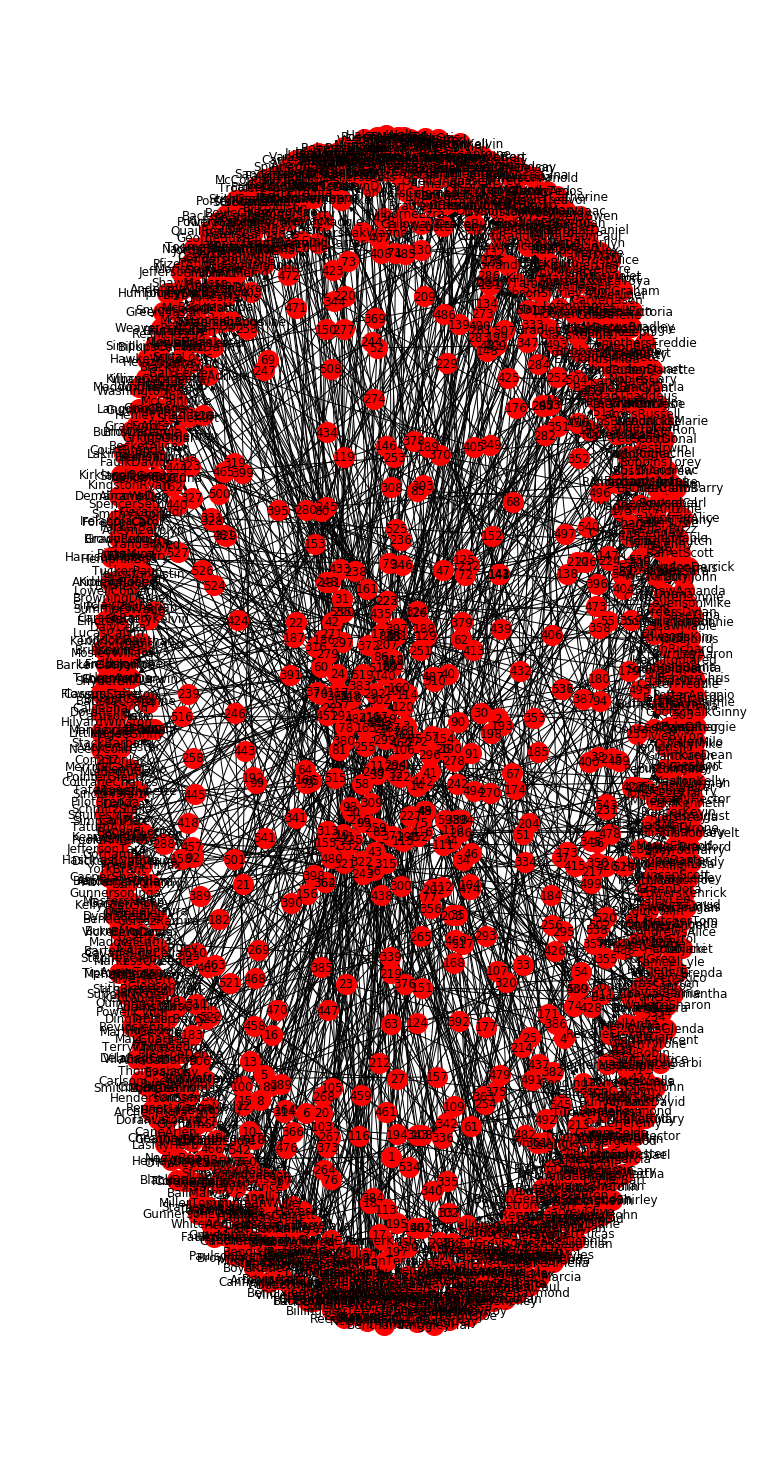

In [45]:
#Make the network graph
G = nx.from_pandas_edgelist(crime,'Crime','Person',create_using=nx.DiGraph())
print(nx.info(G))

nx.draw(G, node_size=400, with_labels=True)

# Island Analysis
Using the island method from SNAFS we isolate the biggest component of the bipartite graph, then we apply the island method and print the threshold level, the size of the graph, and the number of connected components.

In [38]:
#Make graph undirected 
G_ud = G.to_undirected()

#C onnected components
P = bp.weighted_projected_graph(G_ud, person_nodes['Person'].tolist())
list(P.edges(data=True))[0:5]

P_components = list(nx.connected_component_subgraphs(P))

In [33]:
#Functions from SNAFS
def trim_edges( g, weight = 1): 
    g2 = nx.Graph() 
    for f, to, edata in g.edges(data = True): 
        if edata['weight'] > weight: 
            g2.add_edge( f, to, edata) 
    return g2

# Iterates through the graph removing edges and returning the number of edges removed and the trimmed graph
def island_method(g, iterations = 5):
    weights = [edata['weight'] for f,to,edata in g.edges(data=True)]
    mn=int(min(weights))
    mx=int(max(weights))
    step = int((mx-mn)/iterations)
    return [[threshold, trim_edges(g, threshold)] for threshold in [5,20,50,200,350,450,600,1000]]

In [34]:
islands = island_method(P_components[0],4)
islands

[[5, <networkx.classes.graph.Graph at 0x11977c470>],
 [20, <networkx.classes.graph.Graph at 0x11977c048>],
 [50, <networkx.classes.graph.Graph at 0x11977c7b8>],
 [200, <networkx.classes.graph.Graph at 0x11977c5c0>],
 [350, <networkx.classes.graph.Graph at 0x11977c278>],
 [450, <networkx.classes.graph.Graph at 0x11977c198>],
 [600, <networkx.classes.graph.Graph at 0x11977c0f0>],
 [1000, <networkx.classes.graph.Graph at 0x11977ce48>]]

Looking at our function results it looks like something is off when we try to create islands. We should be able to see biggest component of the graphs and isolate them but it is not showing us that.

# Centrality
Since we were not able to see the islands let's take a look at the centrality measures.

In [46]:
deg = nx.degree(G) 
eig = nx.eigenvector_centrality_numpy(G)
clo = nx.closeness_centrality(G)
btw = nx.betweenness_centrality(G)

for index, row in crime.iterrows():
    crime.loc[crime['Person'] == row['Person'], 'degcen'] = deg[row['Person']]
    crime.loc[crime['Person'] == row['Person'], 'eigencen'] = eig[row['Person']]
    crime.loc[crime['Person'] == row['Person'], 'closecen'] = clo[row['Person']]
    crime.loc[crime['Person'] == row['Person'], 'betweencen'] = btw[row['Person']]


In [47]:
print(crime.head(20))

        Person  Crime Relationship            Names Sex  NumRelations  weight  \
0   AbelDennis      1      Suspect       AbelDennis   M             2       4   
1   AbelDennis      2       Victim       AbramsChad   M             2       4   
2   AbelDennis      3       Victim      AbramsDavid   M             2       4   
3   AbelDennis      4      Suspect        AbramsDon   M             2       4   
4   AbramsChad      5       Victim    AbramsRichard   M             4      22   
5   AbramsChad      6      Suspect      AdamsCurtis   M            17      22   
6   AbramsChad      7       Victim      AdamsMartha   F             4      22   
7   AbramsChad      8      Suspect      AdamsReggie   M            17      22   
8   AbramsChad      9      Suspect   AlexanderDevon   M            17      22   
9   AbramsChad     10      Suspect   AlexanderNolan   M            17      22   
10  AbramsChad     11      Suspect   AlexanderTrina   F            17      22   
11  AbramsChad     12      S